In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from konlpy.tag import Mecab
from collections import Counter
import tensorflow as tf

#### 데이터 준비와 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print(len(train_data)) # 리뷰 개수

150000


In [4]:
# NULL 값 확인
print(train_data.isnull().values.any())

True


In [6]:
def has_non_korean_in_column(column):
    # 정규표현식을 사용하여 한글 이외의 문자 판별
    non_korean_pattern = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣]+')

    for text in column:
        if pd.notna(text) and non_korean_pattern.search(str(text)):
            return True  # 한글 이외의 문자가 발견되면 True 반환

    return False  # 모든 텍스트가 한글이거나 null인 경우 False 반환


# 각 열에 대해 확인
for column in train_data.columns:
    if has_non_korean_in_column(train_data[column]):
        print(f"{column}: 한글 이외의 문자가 존재합니다.")
    else:
        print(f"{column}: 모든 텍스트는 한글입니다.")      

id: 한글 이외의 문자가 존재합니다.
document: 한글 이외의 문자가 존재합니다.
label: 한글 이외의 문자가 존재합니다.


In [7]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

/tmp/ipykernel_31/2342004949.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


#### 데이터로더 준비

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [8]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
  
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # "<PAD>", "<BOS>", "<UNK>", "<UNUSED>" 
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{3: '',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '게',
 11: '지',
 12: '있',
 13: '없',
 14: '좋',
 15: '나',
 16: '었',
 17: '만',
 18: '는데',
 19: '너무',
 20: '봤',
 21: '적',
 22: '안',
 23: '정말',
 24: '로',
 25: '것',
 26: '음',
 27: '아',
 28: '네요',
 29: '어',
 30: '지만',
 31: '재밌',
 32: '같',
 33: '진짜',
 34: '에서',
 35: '했',
 36: '기',
 37: '네',
 38: '않',
 39: '거',
 40: '점',
 41: '았',
 42: '수',
 43: '되',
 44: '면',
 45: 'ㅋㅋ',
 46: '인',
 47: '연기',
 48: '말',
 49: '주',
 50: '내',
 51: '평점',
 52: '최고',
 53: '이런',
 54: '던',
 55: '어요',
 56: '할',
 57: '왜',
 58: '겠',
 59: '스토리',
 60: 'ㅋㅋㅋ',
 61: '해',
 62: '습니다',
 63: '듯',
 64: '아니',
 65: '생각',
 66: '드라마',
 67: '더',
 68: '그',
 69: '사람',
 70: '싶',
 71: '때',
 72: '감동',
 73: '배우',
 74: '함',
 75: '본',
 76: '까지',
 77: '알',
 78: '만들',
 79: '뭐',
 80: '내용',
 81: '볼',
 82: '보다',
 83: '감독',
 84: '라',
 85: '그냥',
 86: '재미',
 87: '시간',
 88: '지루',
 89: '중',
 90: '재미있',
 91: '였',
 92: '년',
 93: '잼',
 94: '사랑',
 95: '못',
 96: '냐',
 97: '쓰레기',
 98: '재미없',
 99:

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [11]:
print(X_train[0]) # index로 출력 확인
print(get_decoded_sentence(X_train[0], index_to_word)) # 원래대로 decoding
print('라벨:',y_train[0]) # negative
print('문장 길이:', len(X_train[0])) # 문장 길이 확인

[27, 67, 891, 33, 214, 15, 28, 698]
더 빙 진짜 짜증 나 네요 목소리
라벨: 0
문장 길이: 8


In [12]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차 계산. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이 지정
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  14.443971395827608
문장길이 최대 :  105
문장길이 표준편차 :  11.860017442506944
pad_sequences maxlen :  38
전체 문장의 0.9358376676917014%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
# pre-padding 적용 : 데이터 상의 문장 길이를 통일
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                    value=word_to_index[''],
                                                    padding='pre',
                                                    maxlen=maxlen) # 최대 길이

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                   value=word_to_index[''],
                                                   padding='pre',
                                                   maxlen=maxlen) # 최대 길이

#### 모델 구성 및 validation set 구성

In [14]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(133682, 38)
(133682,)


##### 1) LSTM

In [43]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))  
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력 : 긍정/부정

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [44]:
# 모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
262/262 [==============================] - 3s 7ms/step - loss: 0.4837 - accuracy: 0.7848 - val_loss: 0.3571 - val_accuracy: 0.8452
Epoch 2/5
262/262 [==============================] - 1s 5ms/step - loss: 0.3462 - accuracy: 0.8506 - val_loss: 0.3500 - val_accuracy: 0.8448
Epoch 3/5
262/262 [==============================] - 1s 5ms/step - loss: 0.3286 - accuracy: 0.8599 - val_loss: 0.3519 - val_accuracy: 0.8443
Epoch 4/5
262/262 [==============================] - 1s 5ms/step - loss: 0.3197 - accuracy: 0.8641 - val_loss: 0.3543 - val_accuracy: 0.8430
Epoch 5/5
262/262 [==============================] - 1s 5ms/step - loss: 0.3138 - accuracy: 0.8668 - val_loss: 0.3580 - val_accuracy: 0.8435


In [45]:
# 정규화를 진행 했을 때의 모델 성능 
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3713 - accuracy: 0.8363
[0.37131720781326294, 0.8363000154495239]


In [25]:
'''
#모델 평가 
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

# 정규화를 진행 안했을 때, 모델 성능 epoch = 20 
1537/1537 - 3s - loss: 0.4392 - accuracy: 0.8456
[0.43917882442474365, 0.8455967903137207]
'''

1537/1537 - 3s - loss: 0.4392 - accuracy: 0.8456
[0.43917882442474365, 0.8455967903137207]


In [46]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


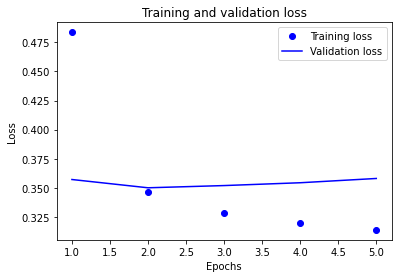

In [47]:
# loss 시각화

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

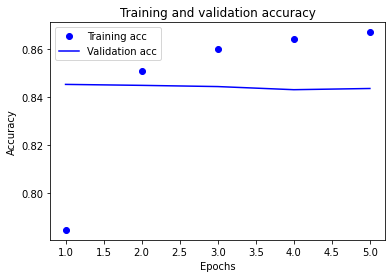

In [48]:
# accuracy 시각화
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
# 학습된 embedding 레이어 분석

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([ 0.13979146,  0.05912843,  0.1503748 ,  0.14114638,  0.15430339,
       -0.07692268, -0.11648965, -0.14745766,  0.06577528, -0.07720248,
       -0.14105736,  0.00092208, -0.07672651,  0.12991297, -0.10636615,
        0.04528306], dtype=float32)

In [51]:
word_vectors.similar_by_word("감동")

[('다정', 0.9575176239013672),
 ('아름다워요', 0.9556894898414612),
 ('비포', 0.9542681574821472),
 ('후유증', 0.9540188908576965),
 ('존경', 0.9489551186561584),
 ('언젠가', 0.947422206401825),
 ('일까요', 0.9473543167114258),
 ('작살', 0.9466667771339417),
 ('엘리베이터', 0.9466245174407959),
 ('즐겼', 0.9465181231498718)]

##### 2) GRU

In [62]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(8))  
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력 : 긍정/부정

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 160,705
Trainable params: 160,705
Non-trainable params: 0
_________________________________________________________________


In [63]:
# 모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
262/262 [==============================] - 3s 6ms/step - loss: 0.5058 - accuracy: 0.7622 - val_loss: 0.3740 - val_accuracy: 0.8353
Epoch 2/5
262/262 [==============================] - 1s 5ms/step - loss: 0.3505 - accuracy: 0.8496 - val_loss: 0.3513 - val_accuracy: 0.8424
Epoch 3/5
262/262 [==============================] - 1s 5ms/step - loss: 0.3311 - accuracy: 0.8597 - val_loss: 0.3527 - val_accuracy: 0.8449
Epoch 4/5
262/262 [==============================] - 1s 5ms/step - loss: 0.3221 - accuracy: 0.8649 - val_loss: 0.3524 - val_accuracy: 0.8443
Epoch 5/5
262/262 [==============================] - 1s 5ms/step - loss: 0.3163 - accuracy: 0.8661 - val_loss: 0.3542 - val_accuracy: 0.8432


In [64]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3695 - accuracy: 0.8362
[0.3695342242717743, 0.8361576199531555]


In [65]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


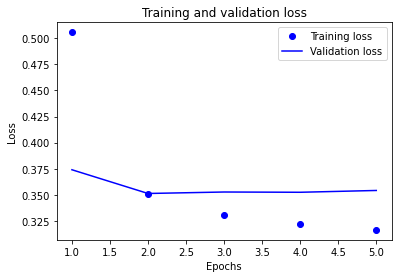

In [66]:
# loss 시각화

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

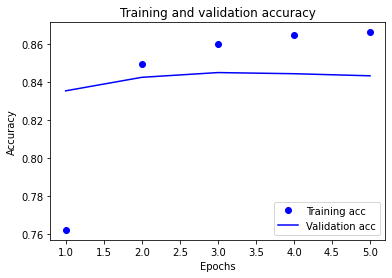

In [67]:
# accuracy 시각화
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [68]:
# 학습된 embedding 레이어 분석

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


In [69]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([ 0.09547806, -0.07093622, -0.15080602, -0.19102998, -0.07419161,
       -0.16584769, -0.07677083, -0.10208535, -0.15270874, -0.1420586 ,
       -0.00604244,  0.03717666, -0.13057178,  0.10706174,  0.17527571,
       -0.14981945], dtype=float32)

In [70]:
word_vectors.similar_by_word("감동")

[('아픔', 0.9695858955383301),
 ('반했', 0.9581789970397949),
 ('지존', 0.9569476246833801),
 ('멋있', 0.9553431868553162),
 ('김민희', 0.955086886882782),
 ('포스', 0.9549335837364197),
 ('감탄', 0.9531253576278687),
 ('울음', 0.9526857137680054),
 ('주행', 0.9526233673095703),
 ('슬픈', 0.9525027275085449)]

##### 3) bidirection LSTM

In [71]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [72]:
# 모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
262/262 [==============================] - 6s 12ms/step - loss: 0.4402 - accuracy: 0.7919 - val_loss: 0.3541 - val_accuracy: 0.8415
Epoch 2/5
262/262 [==============================] - 2s 9ms/step - loss: 0.3415 - accuracy: 0.8518 - val_loss: 0.3549 - val_accuracy: 0.8421
Epoch 3/5
262/262 [==============================] - 2s 9ms/step - loss: 0.3264 - accuracy: 0.8603 - val_loss: 0.3539 - val_accuracy: 0.8451
Epoch 4/5
262/262 [==============================] - 2s 9ms/step - loss: 0.3158 - accuracy: 0.8658 - val_loss: 0.3529 - val_accuracy: 0.8439
Epoch 5/5
262/262 [==============================] - 2s 9ms/step - loss: 0.3025 - accuracy: 0.8731 - val_loss: 0.3614 - val_accuracy: 0.8417


In [73]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3704 - accuracy: 0.8361
[0.37037140130996704, 0.8360762596130371]


In [74]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


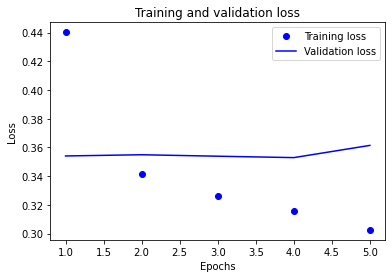

In [75]:
# loss 시각화

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

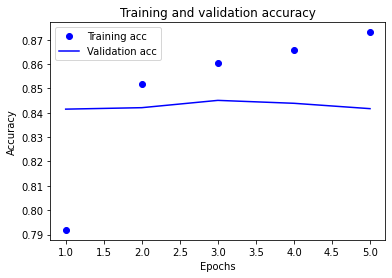

In [76]:
# accuracy 시각화
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [77]:
# 학습된 embedding 레이어 분석

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


In [78]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([-0.06532139, -0.06610582, -0.07786217, -0.0862442 , -0.03051711,
        0.3078114 ,  0.08476271,  0.07207806,  0.05069297,  0.11408205,
       -0.04498557,  0.10960621, -0.0826892 ,  0.07252346,  0.04123539,
       -0.08323634], dtype=float32)

In [79]:
word_vectors.similar_by_word("감동")

[('애절', 0.9432963132858276),
 ('원하', 0.9421605467796326),
 ('기다려', 0.9417463541030884),
 ('졌으면', 0.9395450949668884),
 ('맛있', 0.9373233914375305),
 ('금방', 0.9371804594993591),
 ('애잔', 0.9337471723556519),
 ('과언', 0.9334735870361328),
 ('뛰어넘', 0.9310889840126038),
 ('오랫동안', 0.931069552898407)]

#### 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [83]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path ='/aiffel/data/word2vec_ko.model' 
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary = True, limit = 1000000)
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝'] 
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [85]:
# 의미적 유사도 
similar_words = word_vectors.wv.most_similar('끝', topn=5)

for word, similarity in similar_words:
    print(f'{word}: {similarity}')

마지막: 0.6325399875640869
결판: 0.5526015758514404
발목: 0.5465342402458191
산산조각: 0.5418900847434998
막바지: 0.5412753820419312


In [86]:
# '끝'과 '종료'의 유사도 계산
similarity_score = word_vectors.wv.similarity('끝', '종료')
print(f"유사도: {similarity_score}")

유사도: 0.32932040095329285


In [97]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 word_vectors 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[word]

In [110]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GRU(128))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 38, 100)           1000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 1,089,361
Trainable params: 1,089,361
Non-trainable params: 0
_________________________________________________________________


In [111]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
262/262 [==============================] - 5s 10ms/step - loss: 0.4741 - accuracy: 0.7648 - val_loss: 0.3913 - val_accuracy: 0.8204
Epoch 2/5
262/262 [==============================] - 2s 9ms/step - loss: 0.3483 - accuracy: 0.8460 - val_loss: 0.3360 - val_accuracy: 0.8508
Epoch 3/5
262/262 [==============================] - 2s 9ms/step - loss: 0.3053 - accuracy: 0.8686 - val_loss: 0.3243 - val_accuracy: 0.8556
Epoch 4/5
262/262 [==============================] - 2s 9ms/step - loss: 0.2765 - accuracy: 0.8832 - val_loss: 0.3292 - val_accuracy: 0.8543
Epoch 5/5
262/262 [==============================] - 2s 9ms/step - loss: 0.2524 - accuracy: 0.8961 - val_loss: 0.3235 - val_accuracy: 0.8611


In [112]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3372 - accuracy: 0.8531
[0.33723941445350647, 0.8531439900398254]


In [113]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


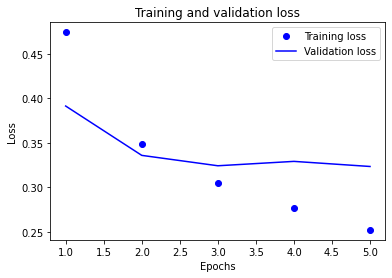

In [114]:
# loss 시각화

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

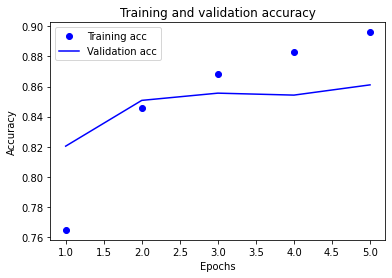

In [115]:
# accuracy 시각화
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [116]:
# 학습된 embedding 레이어 분석

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 100)


In [117]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([ 2.0547924 , -1.8058754 , -3.8978622 ,  0.2008194 ,  3.1024582 ,
       -2.4604864 ,  1.4619311 , -0.95272577, -0.60949105, -0.31318536,
        0.01834296, -1.5167004 , -1.4749508 , -1.3421069 ,  1.3106661 ,
        1.1788899 ,  1.1799655 , -1.2873594 ,  1.3399074 , -0.08145051,
       -2.0551367 ,  2.3700411 ,  2.500924  , -2.454224  , -0.10482638,
        0.34790134, -1.3936205 , -0.9161539 ,  4.11537   , -4.1209617 ,
       -3.770267  ,  0.7044072 , -0.9226187 ,  0.32735318,  0.6919022 ,
        0.27554747, -2.6168387 ,  0.8015034 , -1.8228225 ,  0.67374915,
       -0.848483  , -0.49395764,  1.397693  ,  4.421465  , -1.2023402 ,
        0.5186878 ,  2.299743  , -0.3729462 ,  4.4397473 , -1.482205  ,
        2.0572898 ,  0.7656066 ,  2.955836  , -1.2099615 , -0.87398136,
       -3.7275186 ,  1.5025678 , -0.6335207 ,  0.18944307, -0.45744547,
        1.5932895 , -2.7606888 ,  0.43818223, -2.7609844 ,  0.6981186 ,
        1.0104151 ,  2.056362  ,  0.37777495, -1.40121   , -0.90

In [118]:
word_vectors.similar_by_word("감동")

[('감격', 0.7955742478370667),
 ('감탄', 0.7396145462989807),
 ('매혹', 0.7329134345054626),
 ('매력', 0.7136031985282898),
 ('감명', 0.705360472202301),
 ('열정', 0.696488082408905),
 ('웃음', 0.6899944543838501),
 ('칭찬', 0.6833153963088989),
 ('슬픔', 0.6827161908149719),
 ('감성', 0.6719661355018616)]

#### 회고
* 익숙하지 않은 과정이었지만 나름의 즐거움을 느낄 수 있었다.
* 다른 모델 적용과 from transformers import AutoTokenizer를 이용해보면 어떤 결과가 나올지 궁금하다.
* tokenizer를 비교해보면 어떨지 궁금하다.
* 조금 더 시간적 여유를 가지고 차분히 깊게 들어가보면 좋을 것 같다
